<a href="https://colab.research.google.com/github/talhaanwarch/IDDs_EEG_ML_classification/blob/master/electrode_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages

In this approach data is segmented and feature are calculated for each segment. Then these features are averaged

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
!pip install wfdb
!pip install mne
!pip install nitime
!pip install nolds

     |████████████████████████████████| 122kB 5.6MB/s 
     |████████████████████████████████| 6.9MB 5.0MB/s 
     |████████████████████████████████| 6.2MB 3.6MB/s 
  Created wheel for nitime: filename=nitime-0.9-cp36-cp36m-linux_x86_64.whl size=4030831 sha256=0aefda8045e5f53f3364d5ab7d95c7aff598d6f9109c477ba1bd6e579341210d
  Stored in directory: /root/.cache/pip/wheels/9d/d6/a7/ecbf971b5b91880cbba499bb10d949e84266f24396a916ddb5
Successfully built nitime


In [3]:
!pip install git+https://github.com/forrestbao/pyeeg.git
!pip install git+https://github.com/raphaelvallat/entropy.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-c3nemdwj
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-c3nemdwj
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28123 sha256=a8948b6d4de1cd2923f77b7487ce0a6f1ce73e4be350168557964960c73fab7b
  Stored in directory: /tmp/pip-ephem-wheel-cache-csy953fs/wheels/2d/3f/ad/106d4fc80b61d1ea1fc18e76e7439fd98aa043d83d58eae741
Successfully built pyeeg
  Cloning https://github.com/raphaelvallat/entropy.git to /tmp/pip-req-build-bmah1c8q
  Running command git clone -q https://github.com/raphaelvallat/entropy.git /tmp/pip-req-build-bmah1c8q
  Created wheel for entropy: filename=entropy-0.1.2-cp36-none-any.whl size=15612 sha256=46c5b355de7bd7b41331bc27ee0311671e3ae7fb7b1c983e7baf79accc3cbc85
  Stored in directory: /tmp/pip-ephem-wheel-cache-73npvh01/wheels/60/ed/d3/b715e38438f1f39edb1383aea79c578073953b25fa576fc71e
Successfully built entropy


# Download data

In [4]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fshy54ypyh-1.zip

--2021-01-16 07:43:34--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fshy54ypyh-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.29.88
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.29.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34220065 (33M) [application/octet-stream]
Saving to: ‘fshy54ypyh-1.zip’

fshy54ypyh-1.zip    100%[===================>]  32.63M  19.4MB/s    in 1.7s    

2021-01-16 07:43:36 (19.4 MB/s) - ‘fshy54ypyh-1.zip’ saved [34220065/34220065]



In [5]:
%%capture 
!unzip fshy54ypyh-1.zip

# Read data

In [6]:
from glob import glob
import os
import mne
import re
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import scipy.io


In [7]:
IDD='/content/Data/Data/CleanData/Data/Data/CleanData/CleanData_IDD'
TDC='/content/Data/CleanData/CleanData_TDC'
!rm '/content/Data/Data/CleanData/Data/Data/CleanData/CleanData_IDD/Rest/NDS001_Rest_CD(1).mat'

In [8]:
from scipy import signal
nyq = 0.5 * 128
l=0.5
low = l / nyq
high = 50 / nyq
b, a = signal.butter(3, [low,high], 'band')

In [65]:
IDD_rest=[]
for i in glob(IDD+'/Rest/*.mat'):
    data=scipy.io.loadmat(i)['clean_data'].T
    mu, sigma = np.mean(data), np.std(data)
    noise = np.random.normal(mu, sigma, data.shape)*0.2
    data=data+noise
    data=signal.filtfilt(b, a, data.T).T 
    IDD_rest.append(data)

TDC_rest=[]
for i in glob(TDC+'/Rest/*.mat'):
    data=scipy.io.loadmat(i)['clean_data'].T
    mu, sigma = np.mean(data), np.std(data)
    noise = np.random.normal(mu, sigma, data.shape)*0.2
    data=data+noise
    data=signal.filtfilt(b, a, data.T).T 
    TDC_rest.append(data)

In [66]:
len(IDD_rest),len(TDC_rest)

(7, 7)

In [67]:
print(IDD_rest[0].shape,TDC_rest[0].shape)

(15360, 14) (15360, 14)


In [68]:
X1=np.concatenate(TDC_rest)
X2=np.concatenate(IDD_rest)
X=np.concatenate((X1,X2))
X.shape

(215040, 14)

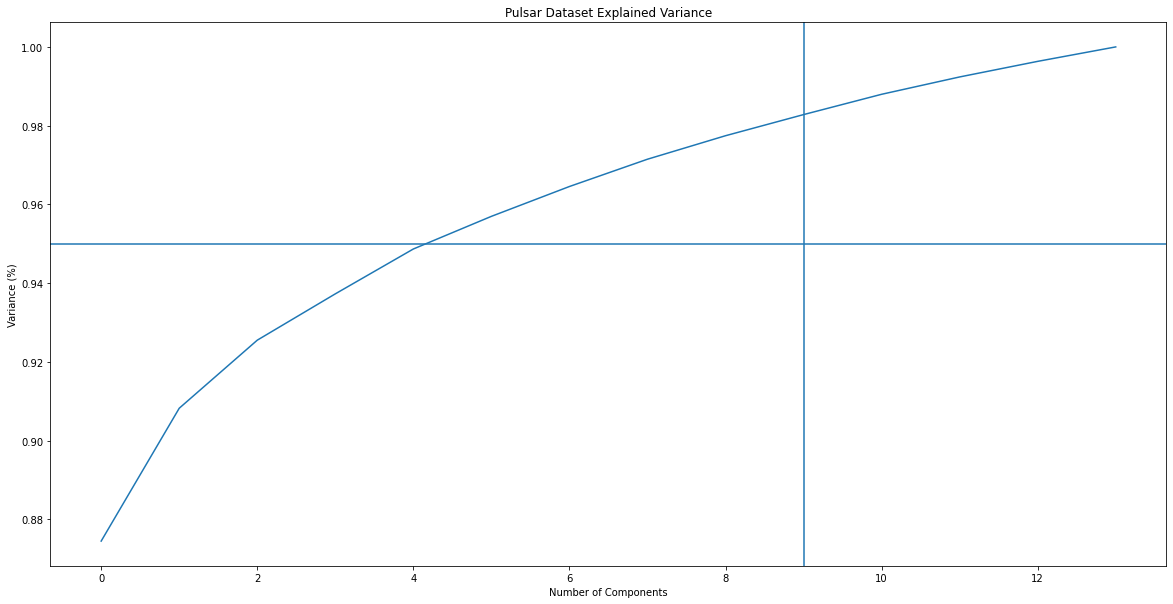

In [69]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
plt.figure(figsize=(20,10))
pca = PCA().fit(X)
plt.axhline(0.95)
plt.axvline(9)
#Plotting the Cumulative Summation of the Explained Variance
plt.plot(np.cumsum(pca.explained_variance_ratio_)[0:15])
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [70]:
channels=['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
df1 = pd.DataFrame.from_records(X)
df1.shape

(215040, 14)

In [71]:
df1.columns=channels
df1.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,-3.843243,0.527196,-10.794113,-1.177101,0.427738,1.275810,2.367516,-14.591719,5.638370,-16.338168,-9.321809,5.082607,-1.751476,-0.171395
1,-4.694445,6.762549,-21.937563,-0.140860,13.155801,7.755729,6.488080,6.486960,-29.556531,-6.046923,-11.467562,11.524912,7.579917,-6.014858
2,-10.335380,11.578296,-21.561904,-2.673558,15.842382,12.787755,12.775338,8.923127,-37.848709,5.107547,-11.903104,14.726536,11.644679,-0.270660
3,-0.111957,12.014923,-28.128736,1.648822,13.335452,18.053102,9.173085,8.365238,-45.628419,10.447234,-15.978099,23.512217,23.481479,10.778133
4,11.873993,17.455438,-30.273390,-5.254458,19.967910,15.560491,0.937717,2.685983,-51.760761,10.505513,-17.768404,29.506540,28.864770,19.593383


In [72]:
ch=4

In [73]:
X_1=df1.var()
idx=X_1.sort_values()[-ch::].index

print(idx)
ch=len(idx)

Index(['AF4', 'F7', 'T8', 'F8'], dtype='object')


In [74]:
indx=[]
for i in idx:
  indx.append(channels.index(i))
indx=np.array(indx)  

In [75]:
indx

array([13,  1,  9, 12])

In [76]:
IDD_reshaped=[]
TDC_reshaped=[]
for i in IDD_rest:
  IDD_reshaped.append(i.reshape(-1,512,14)[:,:,indx])
for i in TDC_rest:
  TDC_reshaped.append(i.reshape(-1,512,14)[:,:,indx])

In [77]:
len(IDD_reshaped),len(TDC_reshaped)

(7, 7)

In [78]:
IDD_reshaped[0].shape

(30, 512, 4)

# Libraries

In [79]:
from scipy import stats
import pyeeg
from entropy import *
import pywt
from nitime import algorithms as alg
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import nolds
np.warnings.filterwarnings('ignore')

# Main Features

In [80]:

from scipy import stats
import pyeeg
from entropy import *
def mean(data):
    return np.mean(data,axis=0)
    
def std(data):
    return np.std(data,axis=0)

def ptp(data):
    return np.ptp(data,axis=0)

def var(data):
        return np.var(data,axis=0)

def minim(data):
      return np.min(data,axis=0)


def maxim(data):
      return np.max(data,axis=0)

def argminim(data):
      return np.argmin(data,axis=0)


def argmaxim(data):
      return np.argmax(data,axis=0)

def mean_square(data):
      return np.mean(data**2,axis=0)

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=0))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)


def skewness(data):
    return stats.skew(data,axis=0)

def kurtosis(data):
    return stats.kurtosis(data,axis=0)

def zero_crossing(data):
    return np.argmax(np.diff(np.sign(data),axis=0),axis=0)

def app_epy(data):
    result=[]
    for i in data.T:
        result.append(app_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)

def perm_epy(data):
    result=[]
    for i in data.T:
        result.append(perm_entropy(i, order=3, normalize=True))
    return np.array(result)

def svd_epy(data):
    result=[]
    for i in data.T:
        result.append(svd_entropy(i, order=3, delay=1, normalize=True))
    return np.array(result)

def spectral_epy(data):
    result=[]
    for i in data.T:
        result.append(spectral_entropy(i, 100, method='welch', normalize=True))
    return np.array(result)

def sample_epy(data):
    result=[]
    for i in data.T:
        result.append(sample_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)


def katz(data):
    result=[]
    for i in data.T:
        result.append(katz_fd(i))
    return np.array(result)

def higuchi(data):
    result=[]
    for i in data.T:
        result.append(higuchi_fd(i))
    return np.array(result)


def petrosian(data):
    result=[]
    for i in data.T:
        result.append(petrosian_fd(i))
    return np.array(result)

def autogressiveModelParameters(data):
    feature = []
    for i in data.T:
        coeff, sig = alg.AR_est_YW(i, order=5)
        feature.append(np.mean(coeff))
    return np.array(feature)

def teager(x):
    for i in range(len(x)-1):
        return x[i]**2 - (x[i-1]*x[i+1])


def lziv_complex(data):
    result=[]
    for i in data.T:
        result.append(lziv_complexity(i))
    return np.array(result)

        
def hjorth_mobility(data):
    return np.divide(np.std(np.diff(data,axis=0),axis=0),np.std(data,axis=0))

def hjorth_complexity(data):
    return np.divide(hjorth_mobility(np.diff(data,axis=0)),  hjorth_mobility(data))      




def concatenate_features(data):
    return np.concatenate((mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),argminim(data),argmaxim(data),
                          mean_square(data),rms(data),abs_diffs_signal(data),
                          skewness(data),kurtosis(data),zero_crossing(data),
                          app_epy(data),perm_epy(data),svd_epy(data),spectral_epy(data),sample_epy(data),
                          katz(data),higuchi(data),petrosian(data),teager(data),lziv_complex(data),
                          hjorth_mobility(data),hjorth_complexity(data)),axis=0)

In [81]:
features1=[]
for f in IDD_reshaped:
    feature=[]
    for i in f:
        feature.append(concatenate_features(i))
    features1.append(np.mean(np.array(feature),axis=0))

In [82]:
features2=[]
for f in TDC_reshaped:
    feature=[]
    for i in f:
        feature.append(concatenate_features(i))
    features2.append(np.mean(np.array(feature),axis=0))

In [83]:
x1=np.array(features1)        
x2=np.array(features2)      

X=np.concatenate((x1,x2),axis=0)

y=np.concatenate(((np.zeros(x1.shape[0])),(np.ones(x2.shape[0]))))
X.shape,y.shape

((14, 104), (14,))

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42,stratify=y)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
clf=SVC(kernel='rbf')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test,y_pred))
print('accuracy is ',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50         2
         1.0       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.25      0.25      0.25         3
weighted avg       0.33      0.33      0.33         3

accuracy is  0.3333333333333333


In [85]:
from sklearn.preprocessing import scale
feature=X.copy()
label=y.copy()
feature=scale(feature)

In [86]:
 from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y,scoring='accuracy'):
    Cs = [ 0.1, 1, 10,15,20,25,30,40,50,60,70,100,120]
    gammas = [0.0001,0.0005,0.001,0.005,0.008, 0.01, 0.1,0.3,0.5, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=KFold(10),scoring=scoring)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_score_


print('accuracy',svc_param_selection(feature,label))
print('f1 macro',svc_param_selection(feature,label,scoring='f1_macro'))

accuracy 0.8
f1 macro 0.8


In [87]:
from sklearn.tree import DecisionTreeClassifier
def dtree_param_selection(X,y,scoring='accuracy'):
    #create a dictionary of all values we want to test
    param_grid = { 'criterion':['gini','entropy'],'max_features':["auto", "sqrt", "log2"],'max_depth': np.arange(2, 20),'random_state':[10,20,30,40,50]}
    # decision tree model
    dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=StratifiedKFold(7),scoring=scoring)
    #fit model to data
    dtree_gscv.fit(X, y)
    #print(dtree_gscv.best_score_)
    #print(dtree_gscv.best_estimator_)
    return dtree_gscv.best_score_

dtree_param_selection(feature,label,scoring='accuracy')
dtree_param_selection(feature,label,scoring='f1_macro')

0.7142857142857143

In [88]:
feature_list=['mean','std','ptp','var','minim','maxim','argmin','argmax','mean_square','rms','abs_diffs_signal','skewness','kurtosis','zero_crossing',
'app_epy','perm_epy','svd_epy','spectral_epy','sample_epy','katz','higuchi','petrosian','teager','lziv_complex',
'hjorth_mobility','hjorth_complexity']

In [89]:
feature_selected=[]
feat_non_sorted=[]
score_non_sorted=[]
for i ,j in zip(range(0,feature.shape[1],ch),feature_list):
  acc=svc_param_selection(feature[:,i:i+ch],label)
  print(j," : ",acc)
  feat_non_sorted.append(j)
  score_non_sorted.append(acc)

mean  :  0.7
std  :  0.65
ptp  :  0.6
var  :  0.45
minim  :  0.6
maxim  :  0.7
argmin  :  0.7
argmax  :  0.65
mean_square  :  0.45
rms  :  0.65
abs_diffs_signal  :  0.6
skewness  :  0.55
kurtosis  :  0.4
zero_crossing  :  0.7
app_epy  :  1.0
perm_epy  :  0.75
svd_epy  :  0.85
spectral_epy  :  0.8
sample_epy  :  1.0
katz  :  0.85
higuchi  :  0.8
petrosian  :  0.75
teager  :  0.05
lziv_complex  :  0.8
hjorth_mobility  :  0.6
hjorth_complexity  :  0.85


In [90]:
print(feat_non_sorted)
print(score_non_sorted)

['mean', 'std', 'ptp', 'var', 'minim', 'maxim', 'argmin', 'argmax', 'mean_square', 'rms', 'abs_diffs_signal', 'skewness', 'kurtosis', 'zero_crossing', 'app_epy', 'perm_epy', 'svd_epy', 'spectral_epy', 'sample_epy', 'katz', 'higuchi', 'petrosian', 'teager', 'lziv_complex', 'hjorth_mobility', 'hjorth_complexity']
[0.7, 0.65, 0.6, 0.45, 0.6, 0.7, 0.7, 0.65, 0.45, 0.65, 0.6, 0.55, 0.4, 0.7, 1.0, 0.75, 0.85, 0.8, 1.0, 0.85, 0.8, 0.75, 0.05, 0.8, 0.6, 0.85]


In [91]:
score,feat  = zip(*sorted(zip(score_non_sorted, feat_non_sorted),reverse=True))


In [92]:
print(feat)
print(score)

('sample_epy', 'app_epy', 'svd_epy', 'katz', 'hjorth_complexity', 'spectral_epy', 'lziv_complex', 'higuchi', 'petrosian', 'perm_epy', 'zero_crossing', 'mean', 'maxim', 'argmin', 'std', 'rms', 'argmax', 'ptp', 'minim', 'hjorth_mobility', 'abs_diffs_signal', 'skewness', 'var', 'mean_square', 'kurtosis', 'teager')
(1.0, 1.0, 0.85, 0.85, 0.85, 0.8, 0.8, 0.8, 0.75, 0.75, 0.7, 0.7, 0.7, 0.7, 0.65, 0.65, 0.65, 0.6, 0.6, 0.6, 0.6, 0.55, 0.45, 0.45, 0.4, 0.05)


In [93]:
# for i, j in zip(feat,score):
#   print(i,j)

In [94]:
def del_item(a, b):
     return [x for x in a if x not in b]



#skf = StratifiedKFold(n_splits=10, random_state=2020, shuffle=False)
acc=0
deleted_item=[]
for i in range(1,20):
  feature_selected=list(feat[:i])
  # feature_selected=del_item(feature_selected,deleted_item)

  X_good=[]
  for key,val in zip(feature_list,range(0,feature.shape[1],ch)):
      for fe in feature_selected:
          if key==fe:     
              #print('key',key,'value',val,":",val+ch) 
              X_good.append(feature[:,val:val+ch])
  good_feature=np.concatenate((X_good),axis=1)
  #good_feature=np.concatenate((good_feature,non_eeg),1)


  acc_new=svc_param_selection(good_feature,label,scoring='f1_macro')
  print(i,' : ', acc_new)

  # print(acc_new, good_feature.shape)
  # if acc_new<(acc-0.01):
  #   deleted_item.append(feature_selected.pop())
  #   print('del item',deleted_item)
  # else:
  #   acc=acc_new


1  :  1.0
2  :  1.0
3  :  1.0
4  :  0.9333333333333332
5  :  0.9
6  :  0.8333333333333333
7  :  0.8333333333333333
8  :  0.8
9  :  0.8333333333333333
10  :  0.8333333333333333
11  :  0.9
12  :  0.9
13  :  0.9
14  :  0.8
15  :  0.8
16  :  0.8
17  :  0.8
18  :  0.8
19  :  0.8


In [95]:
feature_selected=feat[:4]
X_good=[]
for key,val in zip(feature_list,range(0,feature.shape[1],ch)):
    for fe in feature_selected:
        if key==fe:     
            print('key',key,'value',val,":",val+ch) 
            X_good.append(feature[:,val:val+ch])

key app_epy value 56 : 60
key svd_epy value 64 : 68
key sample_epy value 72 : 76
key katz value 76 : 80


In [96]:
good_feature=np.concatenate((X_good),axis=1)
good_feature.shape

(14, 16)

In [97]:
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y):
    Cs = [ 0.1, 1, 10,15,20,25,30,40,50,60,70,100,120]
    gammas = [0.0001,0.0005,0.001,0.005,0.008, 0.01, 0.1,0.3,0.5, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=3)
    grid_search.fit(X, y)
    print(grid_search.best_params_)
    return grid_search.best_score_


svc_param_selection(good_feature,label)


{'C': 1, 'gamma': 0.1}


0.9166666666666666

In [98]:
clf = SVC(kernel="rbf", C=1,gamma=0.1, probability=True)
acc = cross_val_score(clf,good_feature,label,cv=3)
precision = cross_val_score(clf,good_feature,label,cv=3,scoring='precision')
recall = cross_val_score(clf,good_feature,label,cv=3,scoring='recall')
f1 = cross_val_score(clf,good_feature,label,cv=3,scoring='f1')

print('average accuracy : ',np.array(acc).mean(),np.std(np.array(acc)))
print('average precision : ',np.array(precision).mean(),np.std(np.array(precision)))
print('average recall : ',np.array(recall).mean(),np.std(np.array(recall)))
print('average f1 score : ',np.array(f1).mean(),np.std(np.array(f1)))

average accuracy :  0.9166666666666666 0.11785113019775792
average precision :  1.0 0.0
average recall :  0.8333333333333334 0.23570226039551584
average f1 score :  0.8888888888888888 0.15713484026367724


In [99]:
def knn_param_selection(X, y, nfolds):
    n_neighbors  = [ 3,4,5,6,7,8,9]
    weights  = ['uniform','distance']
    metric=['minkowski','manhattan','euclidean']
    param_grid = {'n_neighbors': n_neighbors, 'weights' : weights,'metric':metric}
    grid_search =GridSearchCV( KNeighborsClassifier(), param_grid, cv=nfolds,n_jobs=-1)
    grid_search.fit(X, y)
    print(grid_search.best_score_)
    return grid_search.best_params_


knn_param_selection(good_feature,label,3)

0.85


{'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'}

In [100]:

clf = KNeighborsClassifier(metric= 'minkowski', n_neighbors=5, weights= 'uniform')
acc = cross_val_score(clf,good_feature,label,cv=3)
precision = cross_val_score(clf,good_feature,label,cv=3,scoring='precision')
recall = cross_val_score(clf,good_feature,label,cv=3,scoring='recall')
f1 = cross_val_score(clf,good_feature,label,cv=3,scoring='f1')

print('average accuracy : ',np.array(acc).mean(),np.std(np.array(acc)))
print('average precision : ',np.array(precision).mean(),np.std(np.array(precision)))
print('average recall : ',np.array(recall).mean(),np.std(np.array(recall)))
print('average f1 score : ',np.array(f1).mean(),np.std(np.array(f1)))

average accuracy :  0.85 0.10801234497346433
average precision :  1.0 0.0
average recall :  0.7222222222222222 0.20786985482077452
average f1 score :  0.8222222222222223 0.13698697784375505


In [101]:
from sklearn.linear_model import LogisticRegression
def logistic_param_selection(X, y, nfolds):
    C= [0.001,0.05,0.1, 1,2,3,4,5,8, 10,12,15]
    max_it= [200,300,400,500]
    param_grid = {'C': C,'max_iter':max_it}
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    print(grid_search.best_score_)
    return grid_search.best_params_


logistic_param_selection(good_feature,label,3)

0.7666666666666666


{'C': 1, 'max_iter': 200}

In [102]:
clf = LogisticRegression(max_iter=200,C=1)
acc = cross_val_score(clf,good_feature,label,cv=3)
precision = cross_val_score(clf,good_feature,label,cv=3,scoring='precision')
recall = cross_val_score(clf,good_feature,label,cv=3,scoring='recall')
f1 = cross_val_score(clf,good_feature,label,cv=3,scoring='f1')

print('average accuracy : ',np.array(acc).mean(),np.std(np.array(acc)))
print('average precision : ',np.array(precision).mean(),np.std(np.array(precision)))
print('average recall : ',np.array(recall).mean(),np.std(np.array(recall)))
print('average f1 score : ',np.array(f1).mean(),np.std(np.array(f1)))

average accuracy :  0.7666666666666666 0.20548046676563256
average precision :  0.6666666666666666 0.4714045207910317
average recall :  0.5555555555555555 0.41573970964154905
average f1 score :  0.6 0.43204937989385733


In [103]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
#skf = StratifiedKFold(n_splits=10, random_state=2020, shuffle=False)
def dtree_param_selection(X,y):
    #create a dictionary of all values we want to test
    param_grid = { 'criterion':['gini','entropy'],'max_features':["auto", "sqrt", "log2"],'max_depth': np.arange(2, 20),'random_state':[10,20,30,40]}
    # decision tree model
    dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=3)
    #fit model to data
    dtree_gscv.fit(X, y)
    print(dtree_gscv.best_score_)
    #print(dtree_gscv.best_estimator_)
    return dtree_gscv.best_params_

dtree_param_selection(good_feature,label)

0.8666666666666667


{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'auto',
 'random_state': 30}

In [104]:
clf = DecisionTreeClassifier(criterion= 'gini', max_depth= 2, max_features= 'auto',random_state=30)
acc = cross_val_score(clf,good_feature,label,cv=3)
precision = cross_val_score(clf,good_feature,label,cv=3,scoring='precision')
recall = cross_val_score(clf,good_feature,label,cv=3,scoring='recall')
f1 = cross_val_score(clf,good_feature,label,cv=3,scoring='f1')

print('average accuracy : ',np.array(acc).mean(),np.std(np.array(acc)))
print('average precision : ',np.array(precision).mean(),np.std(np.array(precision)))
print('average recall : ',np.array(recall).mean(),np.std(np.array(recall)))
print('average f1 score : ',np.array(f1).mean(),np.std(np.array(f1)))

average accuracy :  0.8666666666666667 0.09428090415820632
average precision :  1.0 0.0
average recall :  0.7222222222222222 0.20786985482077452
average f1 score :  0.8222222222222223 0.13698697784375505
